In [116]:
import pandas as pd

In [117]:
# Specify your Gretel API key

pd.set_option("max_colwidth", None)

configure_session(api_key='grtu9cd34f3901cfac9e13f08002d42705fcbb214dca7a7731179c6a318cb2af2e0a', cache="yes", validate=True)


Using endpoint https://api.gretel.cloud
Logged in as hoang.nd@orai.io ✅


In [118]:
# Load timeseries example to a dataframe

data_source = "./AAPL Historical Data.csv"
original_df = pd.read_csv(data_source)
original_df.to_csv("original.csv", index=False)
original_df


,Date,Price
0,01/01/2017,908.8
1,01/08/2017,815.3
2,01/15/2017,924.0
3,01/22/2017,919.4
4,01/29/2017,1031.1
...,...,...
150,11/17/2019,7352.6
151,11/24/2019,7599.9
152,12/01/2019,7543.2
153,12/08/2019,7100.8


In [119]:
# Gretel Transforms Configuration
config = """
schema_version: "1.0"
models:
    - transforms:
        data_source: "__tmp__"
        policies:
            - name: shiftnumbers
              rules:
                - name: shiftnumbers
                  conditions:
                    field_name:
                        - Price
                  transforms:
                    - type: numbershift
                      attrs:
                        min: 1
                        max: 100
                        field_name:
                            - Date
              
"""


In [120]:
# De-identify the original dataset using the policy above
import yaml

from gretel_client.projects import create_or_get_unique_project
from gretel_client.helpers import poll

# Create a project and model configuration.
project = create_or_get_unique_project(name="hoangks5")

model = project.create_model_obj(
    model_config=yaml.safe_load(config), data_source=data_source
)

# Upload the training data.  Train the model.
model.submit_cloud()
poll(model)

record_handler = model.create_record_handler_obj(data_source=data_source)
record_handler.submit_cloud()
poll(record_handler)

deid_df = pd.read_csv(record_handler.get_artifact_link("data"), compression="gzip")


MaxRetryError: HTTPSConnectionPool(host='api.gretel.cloud', port=443): Max retries exceeded with url: /projects/hoangks5-ff621779f449273/models?dry_run=no&runner_mode=cloud (Caused by ResponseError('too many 403 error responses'))

In [ ]:
# Here we sort and remove "net_amt" as it's a derived column,
# We will add back in after the data is synthesized
train_df = deid_df.copy()

train_df.sort_values("Date", inplace=True)
train_cols = list(train_df.columns)
train_df = train_df.filter(train_cols)

# Here we noticed that some number have extremely long precision,
# so we round the data
train_df = train_df.round(1)
train_df.to_csv("train.csv", index=False)
train_df


,Date,Price
0,01/01/2017,931.8
105,01/06/2019,3793.0
53,01/07/2018,14245.0
1,01/08/2017,848.3
106,01/13/2019,3836.0
...,...,...
50,12/17/2017,14132.0
103,12/23/2018,3981.0
51,12/24/2017,12422.0
104,12/30/2018,4002.0


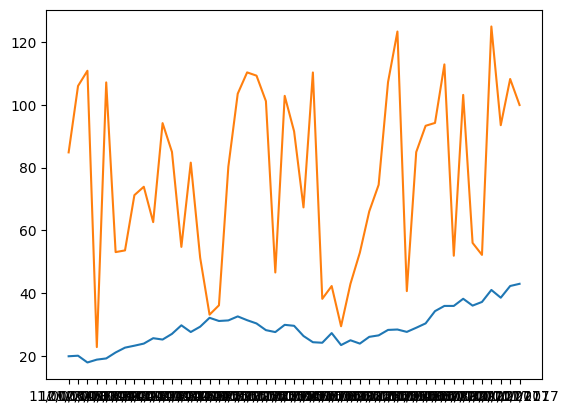

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


data = pd.read_csv('./original.csv')
data_new = pd.read_csv('./train.csv')
plt.plot(data['Date'],data['Price'],data_new['Date'],data_new['Price'])